# Sync soundtrack with video using DTW

Dynamic time warping approach

In [88]:
%matplotlib inline

from collections import Counter
import importlib
import itertools
import math
import sys

import numpy as np, scipy, matplotlib, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pliers
import scenedetect
import videosync_alignment

In [89]:
# print(sys.version)
# !{sys.executable} -m pip install opencv-python

## Load files

In [90]:
# soundtrack_path = "data/01 Why So Serious?.mp3"
# video_path = "data/The Dark Knight - Opening Sequence (2008).mp4"

# # soundtrack_dur, video_dur = 60.0, 120.0 # For initial development
# soundtrack_dur, video_dur = 120.0, 180.0
# # soundtrack_dur, video_dur = 60*9, 60*6 # Basically close to the length of the actual clips

soundtrack_path = "data/10 - Is It Soup Yet?.mp3"
video_path = "data/Ratatouille - Soup Scene (2007).mp4"
soundtrack_dur, video_dur = 60.0, 120.0

n_fft = 4410
hop_size = 2205

# n_fft = 2048
# hop_size = 512

In [91]:
# This is slow
# importlib.reload(videosync_alignment)
# videosync_alignment.align(video_path, soundtrack_path, "./")

In [92]:
# librosa.load?

In [93]:
s, sr = librosa.load(soundtrack_path, duration=soundtrack_dur)
v,_ = librosa.load(video_path, sr=sr, duration=video_dur)

In [94]:
(s.shape, v.shape)

((1323000,), (2646000,))

## Extract chroma

Mostly from the librosa tutorial https://librosa.github.io/librosa/auto_examples/plot_music_sync.html

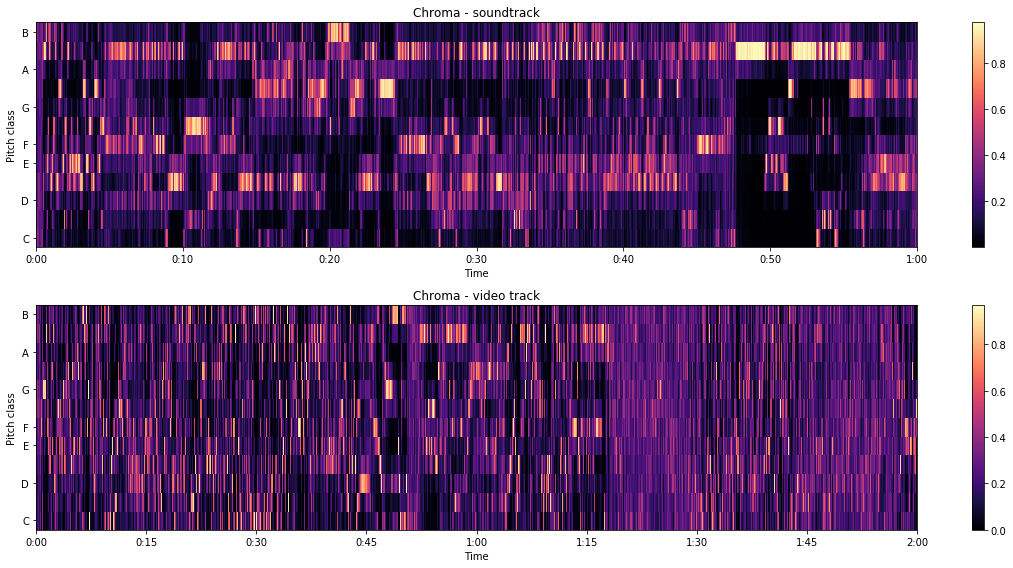

In [95]:
s_chroma = librosa.feature.chroma_stft(y=s, sr=sr, tuning=0, norm=2, hop_length=hop_size, n_fft=n_fft)
v_chroma = librosa.feature.chroma_stft(y=v, sr=sr, tuning=0, norm=2, hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.title("Chroma - soundtrack")
librosa.display.specshow(s_chroma, x_axis="time", y_axis="chroma", hop_length=hop_size)
plt.colorbar()

plt.subplot(2,1,2)
plt.title("Chroma - video track")
librosa.display.specshow(v_chroma, x_axis="time", y_axis="chroma", hop_length=hop_size)
plt.colorbar()

plt.tight_layout()

In [96]:
(s_chroma.shape, v_chroma.shape)

((12, 2584), (12, 5168))

## Align chroma sequences

In [97]:
D, wp = librosa.core.dtw(X=s_chroma, Y=v_chroma, subseq=True)
wp_s = np.asarray(wp) * hop_size / sr

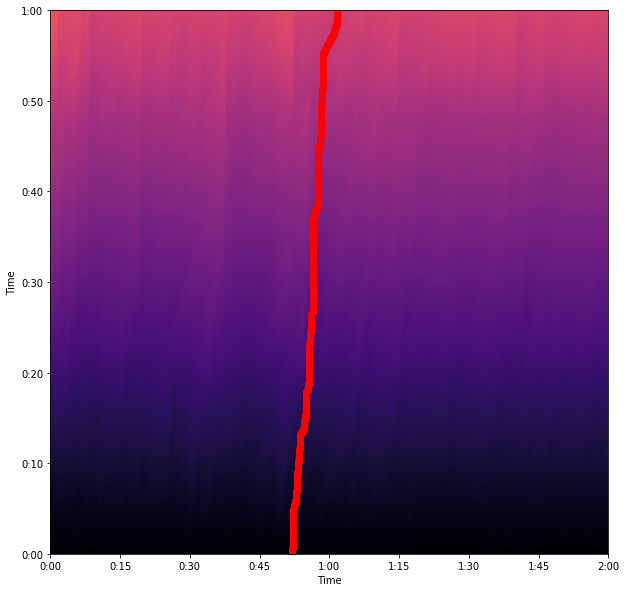

In [98]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis="time", y_axis="time", hop_length=hop_size)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker="o", color="r")

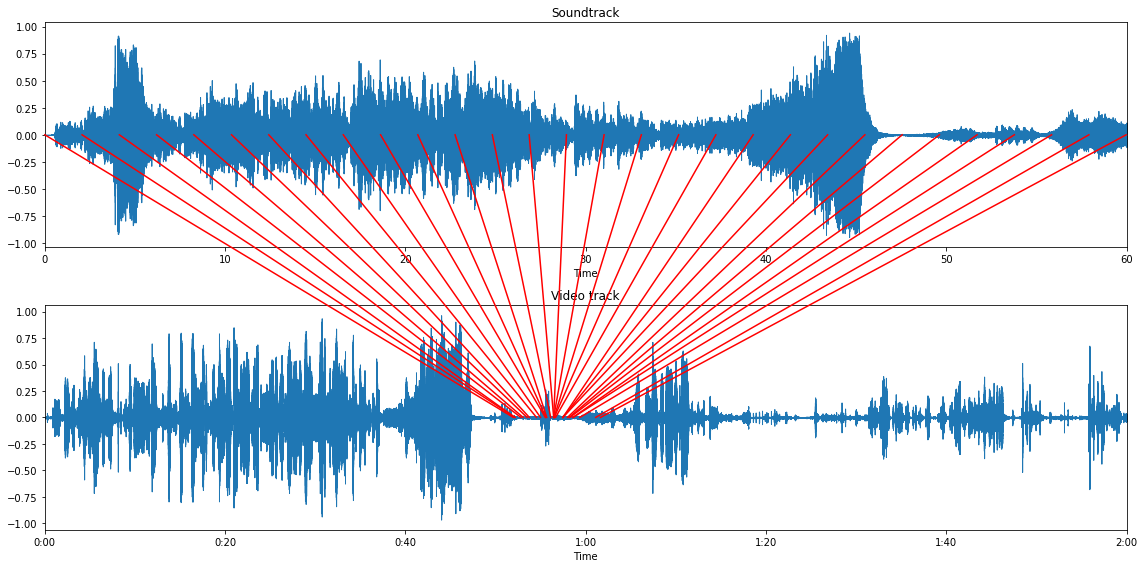

In [99]:
fig = plt.figure(figsize=(16, 8))

# Plot soundtrack
plt.subplot(2, 1, 1)
librosa.display.waveplot(s, sr=sr)
plt.title("Soundtrack")
ax1 = plt.gca()

# Plot video track
plt.subplot(2, 1, 2)
librosa.display.waveplot(v, sr=sr)
plt.title('Video track')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

for tp1, tp2 in wp[points_idx] * hop_size / sr:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color="r")
    lines.append(line)

fig.lines = lines
plt.tight_layout()

## Try to find optimal sync point

Plot it to visualize:

In [100]:
wp_s[-1]

array([  0.       ,  51.9662585])

In [101]:
wp_s.T

array([[  5.99771429e+01,   5.99539229e+01,   5.99307029e+01, ...,
          4.64399093e-02,   2.32199546e-02,   0.00000000e+00],
       [  6.16489796e+01,   6.16489796e+01,   6.16489796e+01, ...,
          5.19662585e+01,   5.19662585e+01,   5.19662585e+01]])

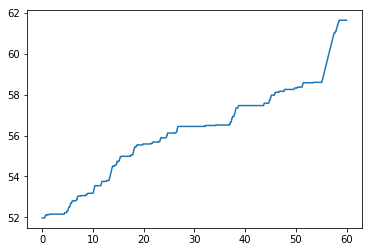

In [102]:
plt.plot(wp_s.T[0], wp_s.T[1])

In [103]:
# wp_s_rev = np.flip(wp_s.T, axis=1)
# plt.plot(wp_s_rev[0], wp_s_rev[1])

Get the slope of soundtrack:

In [104]:
s_gradients = np.gradient(wp_s.T[0])
s_gradients = np.around(s_gradients, decimals=3)
s_gradient_counts = Counter(s_gradients)
s_gradient = s_gradient_counts.most_common(1)[0][0]
s_gradient

-0.023

In [105]:
len(np.where(s_gradients == s_gradient)[0])

2583

In [106]:
len(s_gradients)

2585

Try to match it w slopes of subsequence in video track:

In [107]:
v_gradients = np.gradient(wp_s.T[1])
v_gradients = np.around(v_gradients, decimals=3)
v_gradient_matches = np.where(v_gradients == s_gradient)[0]
v_gradient_matches

array([  62,   68,   69,   70,   71,   72,   77,   78,   79,   80,   81,
         82,   83,   84,   85,   86,   87,   88,   94,   95,   96,  107,
        108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,
        119,  120,  121,  122,  123,  124,  125,  126,  127,  128,  129,
        130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
        141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
        152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,
        163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
        174,  175,  176,  177,  178,  179,  180,  181,  182,  183,  184,
        185,  186,  187,  188,  189,  190,  191,  192,  193,  194,  195,
        196,  197,  198,  199,  200,  201,  202,  203,  204,  205,  206,
        207,  208,  209,  369,  370,  371,  372,  373,  374,  375,  376,
        443,  444,  528,  529,  530,  608,  609,  610,  611,  639,  640,
        641,  642,  645,  646,  647,  648,  649,  6

In [108]:
# wp_s[590]

Then find the longest sequence of matches:

In [109]:
def find_lcis(a): # Longest consecutive increasing subsequence
    lcis = []
    cur_seq = []
    for i in range(len(a)):
        if i == 0 or len(cur_seq) == 0 or a[i-1] + 1 == a[i]:
            cur_seq.append(a[i])
        else:
            if len(cur_seq) > len(lcis):
                lcis = cur_seq
            cur_seq = []
    return lcis

In [110]:
v_gradient_lcis = find_lcis(v_gradient_matches)
v_gradient_lcis

[108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209]

In [111]:
lcis_i = v_gradient_lcis[0]
match_times = wp_s[lcis_i]
st, vt = match_times[0], match_times[1]
st, vt

(57.469387755102041, 60.975600907029481)

What this means is we want 0:42 of the soundtrack to line up with 1:34 of the video track.

So let's make that happen:

## Create synced tracks

Get the difference in times (i.e. where 0:00 of the earlier track should occur):

In [112]:
st_vt_diff = abs(st - vt)
st_vt_diff

3.5062131519274402

Add offset padding to the earlier-occurring track, to align them:

In [113]:
s_aligned = s
v_aligned = v
offset_samps = librosa.time_to_samples(st_vt_diff, sr=sr)

if st < vt:
    s_aligned = np.concatenate((np.zeros(offset_samps), s), axis=0)
else:
    v_aligned = np.concatenate((np.zeros(offset_samps), v), axis=0)


In [114]:
offset_samps

array([77312])

In [115]:
librosa.frames_to_time(len(s), sr=sr)

array([ 30720.])

In [116]:
librosa.time_to_samples(st_vt_diff)

array([77312])

In [117]:
librosa.samples_to_time(len(s_aligned), sr=sr)

array([ 63.50621315])

In [118]:
# np.concatenate?

In [119]:
# librosa.time_to_frames(match_times, sr=sr)

In [120]:
# c = itertools.count()
# val = max((list(g) for _, g in groupby(v_gradient_matches, lambda x: x-next(c))), key=len)
# val

Make both tracks the same duration, for convenience:

In [121]:
# By shortening the longer track
# length = min(len(s), len(v))
# s = s[:length]
# v = v[:length]

# By end-padding the shorter track
sv_length_diff = abs(len(s_aligned) - len(v_aligned))
if len(s_aligned) < len(v_aligned):
    s_aligned = np.concatenate((s_aligned, np.zeros(sv_length_diff)), axis=0)
elif len(v_aligned) < len(s_aligned):
    v_aligned = np.concatenate((v_aligned, np.zeros(sv_length_diff)), axis=0)

(len(s_aligned), len(v_aligned))

(2646000, 2646000)

In [122]:
ipd.Audio(s_aligned + v_aligned, rate=sr)

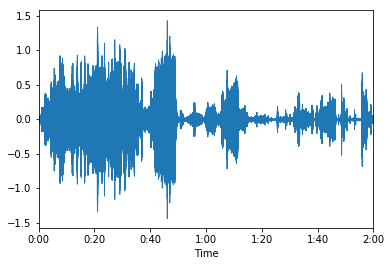

In [123]:
librosa.display.waveplot(s_aligned + v_aligned, sr=sr)

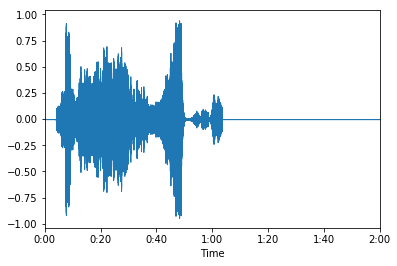

In [124]:
librosa.display.waveplot(s_aligned, sr=sr)

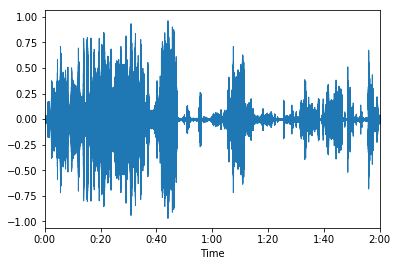

In [125]:
librosa.display.waveplot(v_aligned, sr=sr)

## Aligning more naively

Let's just take the *first* sample:

In [126]:
# wp_s[-1]

In [127]:
# st_vt_diff = abs(wp_s[-1][0] - wp_s[-1][1])
# st_vt_diff

In [128]:
# # Pad at beginning (to align)
# offset_samps = librosa.time_to_samples(st_vt_diff, sr=sr)
# s_aligned, v_aligned = s, v

# if st < vt:
#     s_aligned = np.concatenate((np.zeros(offset_samps), s), axis=0)
# else:
#     v_aligned = np.concatenate((np.zeros(offset_samps), v), axis=0)

# # Pad at end (to normalize duration) 
# sv_length_diff = abs(len(s_aligned) - len(v_aligned))
# if len(s_aligned) < len(v_aligned):
#     s_aligned = np.concatenate((s_aligned, np.zeros(sv_length_diff)), axis=0)
# elif len(v_aligned) < len(s_aligned):
#     v_aligned = np.concatenate((v_aligned, np.zeros(sv_length_diff)), axis=0)

In [129]:
# librosa.display.waveplot(s_aligned, sr=sr)

In [130]:
# ipd.Audio(s_aligned + v_aligned, rate=sr)